## NTDS project

In [2]:
import pandas as pd
import gzip
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None

---
## Data loading

In [2]:
# Funtions for data loading
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)
        
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [4]:
# Data loading
df_product = getDF('data/meta_Electronics.json.gz')
df_review = getDF('data/reviews_Electronics_5.json.gz')

# Generate pickle file
df_product.to_pickle('data/origin_product.pkl')
df_review.to_pickle('data/origin_review.pkl')

---
## Data pre-processing for electronic product reviews dataset

### Collect all reviewers' ID for each product

In [ ]:
df_product_reviewer = pd.DataFrame(df_review.groupby(['asin'])['reviewerID'].apply(list))
df_product_reviewer.to_pickle('data/product_reviewer.pkl')

In [ ]:
df_product_reviewer.head()

In [ ]:
print("There are {} electronic products who have at least 5 reviews in our dataset.".format(df_product_reviewer.shape[0]))

### Collect all reviewers' ID

In [ ]:
reviewers = set([x for list_ in df_product_reviewer['reviewerID'].values for x in list_])

In [ ]:
print("There are {} reviewers who has commented on at least on product in our dataset.".format(len(reviewers)))

---
## Data pre-processing for electronic product dataset

In [ ]:
# Drop useless columns
df_product.drop(['imUrl','salesRank','brand','description','categories','title','price'],axis=1,inplace=True)

# Drop rows which related column is Nan value
df_product = df_product[df_product['related'].notnull()]

# Collect all electronic products' asin
product_asin = df_product['asin'].values

df_product.to_pickle('data/product_with_related.pkl')

#### Clean two datasets, only keep products which present in both metadata and review datasets

In [83]:
product_with_review_asin = df_product_reviewer.index.values
product_asin = df_product['asin'].values

##### Check if all products which possess reviews have the corresponding product description in metadata dataset

In [91]:
list(set(product_asin) & set(product_with_review_asin)) == list(product_with_review_asin)

False

##### As the return value of the cell above is false, we are supposed to drop products in both datasets

In [92]:
num_product = len(list(set(product_asin) & set(product_with_review_asin)))
print("There are {} electronic products in both metadata and review datasets".format(num_product))

60682

In [93]:
# Clean review dataset and generate new pickle file
product_to_keep_asin = list(set(product_asin) & set(product_with_review_asin))
df_product_reviewer_new = df_product_reviewer.loc[product_to_keep_asin]
df_product_reviewer_new.to_pickle('data/review_intersection.pkl')

# Clean product dataset and generate new pickle file
df_product.set_index(['asin'],inplace=True)
df_product = df_product.loc[product_to_keep_asin]
df_product.to_pickle('data/product_intersection.pkl')

### Create also_viewed relation dataframe

We only keep also_viewed products which are also in the category electronic.

In [20]:
df_product = pd.read_pickle('data/product_intersection.pkl')
product_asin = df_product.index.values

In [26]:
def also_viewed(x):
    if 'also_viewed' in x.keys():
        temp = []
        for asin in x['also_viewed']:
            if asin in product_asin:
                temp.append(asin)
        return temp
    else:
        return []

In [27]:
df_product['also_viewed'] = df_product['related'].apply(lambda x: also_viewed(x))

### Create also_bought relation dataframe

We only keep also_bought products which are also in the category electronic.

In [ ]:
def also_bought(x):
    if 'also_bought' in x.keys():
        temp = []
        for asin in x['also_bought']:
            if asin in product_asin:
                temp.append(asin)
        return temp
    else:
        return []

In [ ]:
df_product['also_bought'] = df_product['related'].apply(lambda x: also_bought(x))

In [ ]:
df_product.to_pickle('data/product_also_viewed_bought.pkl')

---
### Only keep also_bought relation

In [10]:
df_product_vb = pd.read_pickle('data/product_also_viewed_bought.pkl')

In [30]:
df_product_vb.head()

,related,also_viewed,also_bought
asin,,,
B0083S3NC8,"{'also_bought': ['B005GU0DXS', 'B0086I58IW', '...",[],"[B007W1KES8, B005KQ0S8S, B007W1KEFG, B005F15N2..."
B0047FHOWG,"{'also_bought': ['B0019SHZU0', 'B002ZIMEMW', '...",[],"[B0019SHZU0, B002ZIMEMW, B002HJ9PTO, B004AZ38Z..."
B0067SJC80,"{'also_bought': ['B000X1R5HM', 'B004MU8VCS', '...",[],"[B000X1R5HM, B004MU8VCS, B002YIG9AQ, B005CTCD6..."
B002WQP2IA,"{'also_bought': ['B000U0HAR6', 'B005QCPG9C', '...",[],"[B000U0HAR6, B000068O4E, B000068O4C, B00356J8K..."
B006IC4YZQ,"{'also_bought': ['B00ICS8OF0', 'B004OEBMAK', '...",[],"[B001G54ILA, B005SDWP3O, B0036QL1JY]"


In [32]:
df_product_bought = df_product_vb[['also_bought']]
df_product_bought['also_bought'] = df_product_bought['also_bought'].apply(lambda x: 'unknown' if x == [] else x)
df_product_bought = df_product_bought[~(df_product_bought['also_bought'] == 'unknown')]

In [37]:
also_bought_index = df_product_bought.index.values
for asin in also_bought_index:
    new_related = []
    for related in df_product_bought.loc[asin].also_bought:
        if related in also_bought_index:
            new_related.append(related)
    df_product_bought.loc[asin].also_bought = new_related

In [38]:
# Generate also_bought relation pickle file
df_product_bought.to_pickle('data/product_also_bought.pkl')

In [39]:
# Update review dataset
# Only keep reviews concerning the products which exist in new product dataset 
all_product = df_product_bought.index.values
df_review = pd.read_pickle('data/review_intersection.pkl')
df_review_bought = df_review.loc[all_product]
df_review_bought.to_pickle('data/review_also_bought.pkl')

---
## Data after pre-processing

In [3]:
df_product = pd.read_pickle('data/product_also_bought.pkl')
df_review = pd.read_pickle('data/review_also_bought.pkl')

In [4]:
print("Ultimately, we decide to keep {} electronic products to conduct our project".format(df_product.shape[0]))

Ultimately, we decide to keep 43276 electronic products to conduct our project


---
## Research about Macbook and Surface on 'Also-Bought'

In [14]:
def get_all_related_asin_from_list_asin(list_asin):
    res = []
    for asin in list_asin:
        res.extend(df_product.loc[asin]['also_bought'])
    res = list(set(res))
    return res

In [15]:
# Macbook
nb_layer = 2
df_mac = df_product[df_product.index == 'B005CWJB5G']
list_asin = ['B005CWJB5G']
for i in range(nb_layer):
    index = get_all_related_asin_from_list_asin(list_asin)
    df_mac = pd.concat([df_mac,df_product.loc[index]])
    list_asin = index
df_mac = df_mac.reset_index().drop_duplicates(subset='asin')
df_mac.shape

(743, 2)

In [16]:
# Surface
nb_layer = 2
df_surface = df_product[df_product.index == 'B00FG7MVJU']
list_asin = ['B00FG7MVJU']
for i in range(nb_layer):
    index = get_all_related_asin_from_list_asin(list_asin)
    df_surface = pd.concat([df_surface,df_product.loc[index]])
    list_asin = index
df_surface = df_surface.reset_index().drop_duplicates(subset='asin')
df_surface.shape

(499, 2)

In [17]:
dupasin = list(set(df_mac.asin.values) & set(df_surface.asin.values))

In [18]:
df_mac_new = df_mac.set_index('asin').drop(dupasin)

In [19]:
df_mac_new.shape

(609, 1)

In [20]:
df_all = pd.concat([df_mac_new.reset_index(), df_surface])
df_all.shape

(1108, 2)

In [21]:
df_all.head()

,asin,also_bought
0,B005CWJB5G,"[B004R6J2V6, B007FL7GGS, B0077EVNY4, B008AL9VX..."
1,B007472CIK,"[B004R6J2V6, B009V17TH6, B008AL9VXI, B002TLTGM..."
2,B005CWJ8YA,"[B004BQTSKC, B004H3OVRO, B00746YHV6, B004H3UZ2..."
3,B002WUVAVE,"[B002HU629E, B003BERYLA, B00969J3EU, B003BHHIA..."
4,B002TLTGM6,"[B005DLDO4U, B005DLDTAE, B007476KRY, B008AL9VX..."


---
### Spectral Graph Theory

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

In [73]:
G = nx.Graph()

In [74]:
G.add_nodes_from(df_all.asin.values)

In [159]:
#for i in range(len(df_all)):
#    for x in df_all.iloc[i]['also_bought']:
#        if x not in G.node:
#            G.add_node(x)    
#        if G.has_edge(df_all.iloc[i]['asin'], x):
#            G[df_all.iloc[i]['asin']][x]['weight']+=1
#        else:
#            G.add_edge(df_all.iloc[i]['asin'], x, weight=1)

### # of same *also_bought* as the weight

In [344]:
for i in range(len(df_all)):
    for j in range(i+1, len(df_all)):
        set_len = len(set(df_all.iloc[i]['also_bought'])&set(df_all.iloc[j]['also_bought']))
        G.add_edge(df_all.iloc[i]['asin'], df_all.iloc[j]['asin'], weight=set_len)

In [345]:
A = nx.adjacency_matrix(G,weight='weight')
A.todense()

matrix([[ 0,  8,  5, ...,  1,  0,  0],
        [ 8,  0,  6, ...,  1,  0,  0],
        [ 5,  6,  0, ...,  0,  0,  0],
        ..., 
        [ 1,  1,  0, ...,  0, 22,  2],
        [ 0,  0,  0, ..., 22,  0,  1],
        [ 0,  0,  0, ...,  2,  1,  0]], dtype=int64)

### Calculate the Similarity Matrix by Normalizing the Maximum as 1

In [346]:
similar = A.todense()/A.max()
np.fill_diagonal(similar,0)

In [347]:
A.max()

47

### Only Keep the TOP K Neighbors 

In [348]:
weights = similar.getA().copy()
NEIGHBORS = 50

# Keep only the K strongest edges
# By making weights of all other edges equal to 0
ind = np.argsort(weights)[:,::-1][:,NEIGHBORS:]
for i in range(weights.shape[1]):
    weights[i][ind[i]]=0
    
# Make it symmestric
bigger = weights.transpose() > weights
weights = weights - weights*bigger + weights.transpose()*bigger

In [349]:
weights

array([[ 0.        ,  0.        ,  0.10638298, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.12765957, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.10638298,  0.12765957,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.46808511,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.46808511,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### Calculate the Laplacian

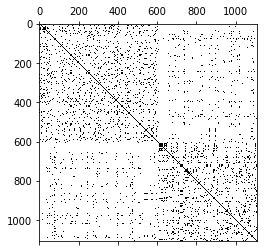

In [350]:
degrees = np.sum(weights, axis=0)
D = np.diag(degrees)
D_0_5 = np.diag(1./np.sqrt(degrees))
laplacian = np.dot(D_0_5, np.dot((D - weights), D_0_5))
plt.spy(laplacian)
plt.show()

In [351]:
from scipy import sparse, stats, spatial
laplacian = sparse.csr_matrix(laplacian)

In [352]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=10, which='SM')

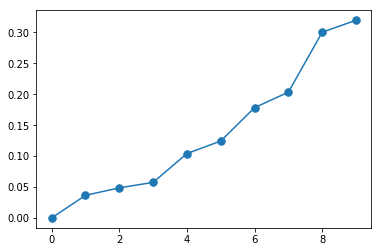

In [353]:
plt.plot(eigenvalues, '.-', markersize=15);

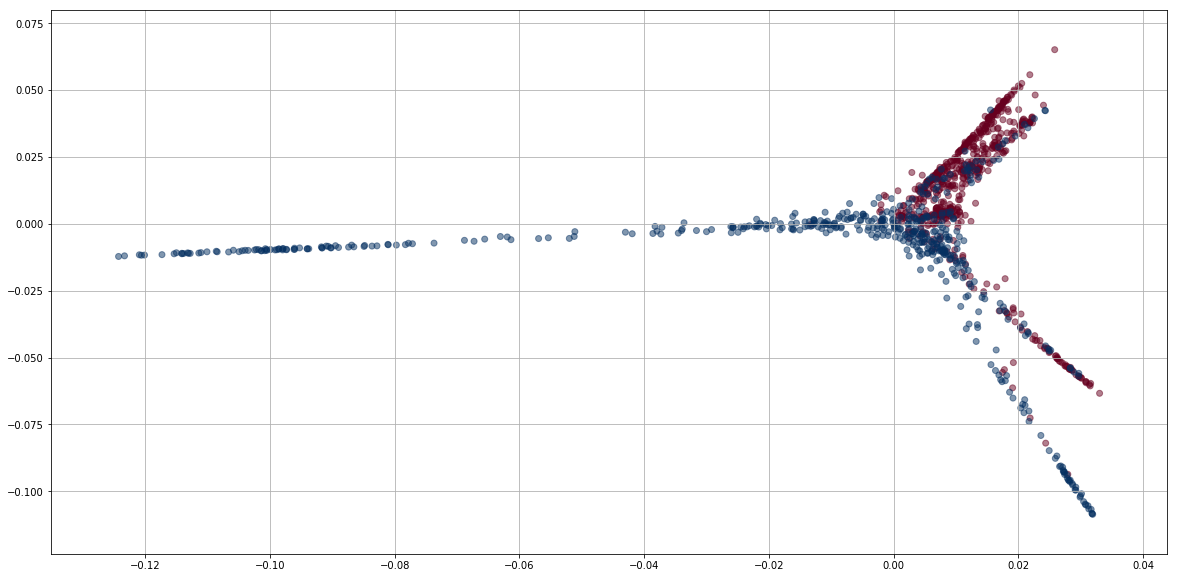

In [397]:
x1 = eigenvectors[:,1]
y1 = eigenvectors[:,2]
labels = np.ones(A.shape[0])
labels[0:609] = 0
plt.figure(figsize=(20,10))
plt.scatter(x1, y1, c=labels, cmap='RdBu', alpha=0.5)
plt.grid()

In [400]:
np.sum((x1<0) != labels)/len(labels)

0.26173285198555957

In [371]:
len(G.nodes)

1108

### Transductive Learning

In [385]:
# Ground truth.
x = np.ones(len(G.nodes))
x[0:609] = -1

def prepare_observations(p):
    """Prepare observations, where p is the percentage of values to keep."""
    rs = np.random.RandomState(42)
    M = np.diag(rs.uniform(size=len(G.nodes)) < p)
    return M.dot(x)

# Play with the percentage of observed values.
y = prepare_observations(p=0.1)

In [386]:
def solve(y, alpha):
    """
    Solve the optimization problem.
    
    Parameters:
        y: the observations
        alpha: the balance between fidelity and smoothness prior.
    
    Returns:
        x_pred: the predicted class
        x_star: the solution of the optimization problem
    """
    
    M = np.diag(y!=0)
    
    x_star = np.linalg.solve(M+alpha*laplacian, M.dot(y))
    
    x_pred = np.ones(len(G.nodes))
    x_pred[x_star<0] = -1
    
    return x_pred, x_star

x_pred, x_star = solve(y, alpha=1)

# Be sure that the prediction is binary.
np.testing.assert_equal(abs(x_pred), 1)

# Error rate.
#err = np.sum(np.abs(x - x_pred))
err = np.sum(x != x_pred)
print('{} errors ({:.2%})'.format(err, err/len(G.nodes)))

223 errors (20.13%)


In [387]:
alpha = 0.1

for p in [0.1, 0.3, 0.5, 0.7, 0.9]:
    y = prepare_observations(p)
    x_pred, _ = solve(y, alpha)
    err = np.sum(x != x_pred)
    print('{}: {:6.2%}'.format(p, err/len(G.nodes)))

0.1: 17.24%
0.3:  8.66%
0.5:  5.96%
0.7:  3.88%
0.9:  1.90%


### Prediction

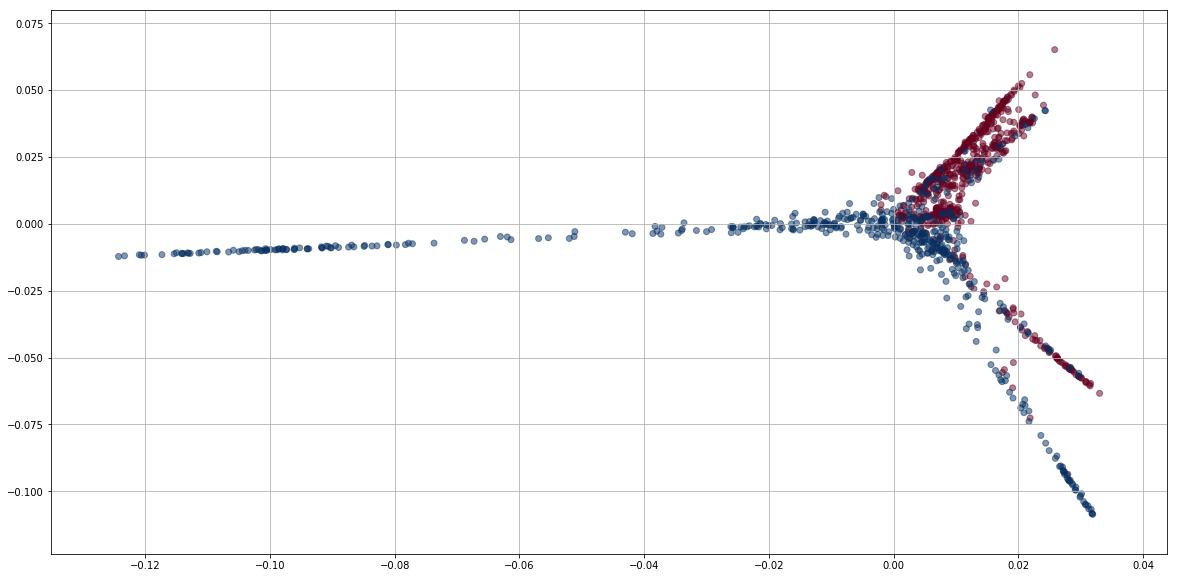

In [392]:
x1 = eigenvectors[:,1]
y1 = eigenvectors[:,2]
plt.figure(figsize=(20,10))
plt.scatter(x1, y1, c=x_pred, cmap='RdBu', alpha=0.5)
plt.grid()

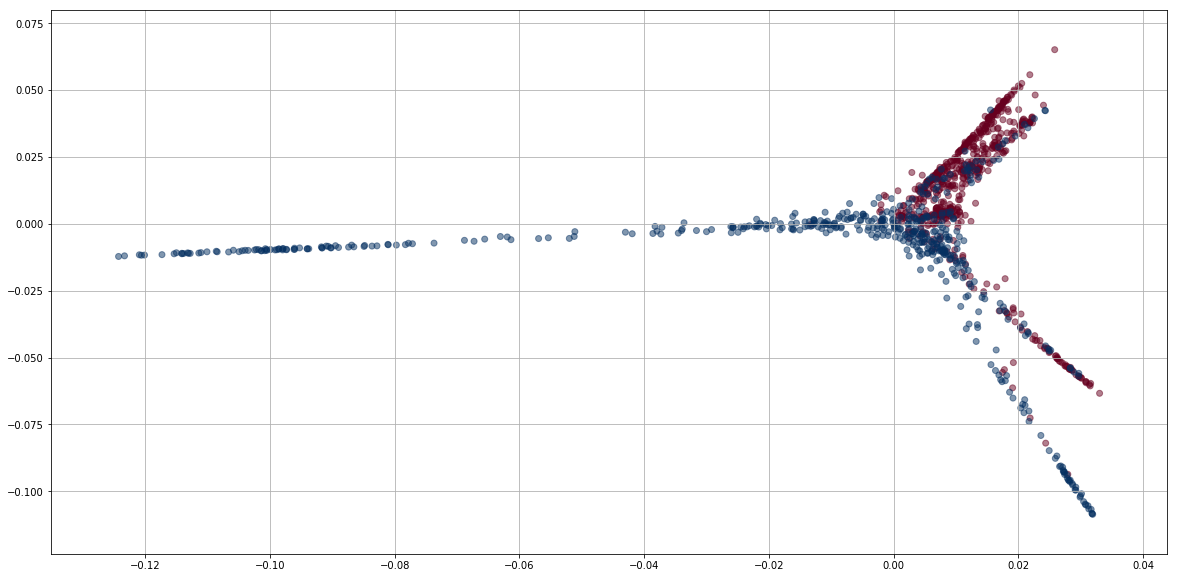

In [394]:
x2 = eigenvectors[:,1]
y2 = eigenvectors[:,2]
plt.figure(figsize=(20,10))
labels = np.ones(A.shape[0])
labels[0:609] = -1
plt.scatter(x2, y2, c=labels, cmap='RdBu', alpha=0.5)
plt.grid()

---
## Research about Macbook and Surface on 'Reviewer'

In [5]:
df_review.head()

,reviewerID
asin,
B0083S3NC8,"[A18I2DO90GZCQY, A2C4BO8UURNWNN, A2RF9FHC4HC3J..."
B0047FHOWG,"[A3OTFTP2WVZVQY, A10KIQXOE926FN, A1Q165PZVZS34..."
B0067SJC80,"[A3QLALFN0WGF87, A395EVHF1TAQN0, AOEDXOKYPII2Z..."
B002WQP2IA,"[AN3ILH8NOGNH4, A3FGRP5N72WES1, ADN4437IJDIPP,..."
B006IC4YZQ,"[A3W3PWGZ36249Y, AZLDKR28KT3FB, A3M3DL4G9NS3Z2..."


In [12]:
len(df_review.loc['B005CWJB5G'].values[0])

113

In [13]:
len(df_review.loc['B00FG7MVJU'].values[0])

42

In [65]:
b = df_review.loc['B00FG7MVJU'].values[0][12:13]

In [70]:
a = 0
for i in df_review.index:
    if 'A15QYHQH80W30L' in df_review.loc[i].reviewerID and 'AVPNQUVZWMDSX' in df_review.loc[i].reviewerID:
        a+=1

In [71]:
a

2

In [68]:
d = dict()
for r in df_review.loc['B00FG7MVJU'].values[0]:
    d[r] = 0
    for i in df_review.index:
        if r in df_review.loc[i].reviewerID:
            d[r]+=1

In [72]:
d

{'A13Y80N3FJJ31I': 12,
 'A1432LL78DCX4G': 12,
 'A15QYHQH80W30L': 92,
 'A19IUOWRTAMJP3': 10,
 'A1A9GGUTZQEX8D': 7,
 'A1E9QPX0866W00': 18,
 'A1FRIBXUEIRNQ3': 19,
 'A1JPGBJAKTJEIL': 14,
 'A1LBZ6ZC4CJ78M': 4,
 'A1P5IP5LA4110N': 5,
 'A1R0OO5SH7NC3P': 6,
 'A1WV4VF9PVRRYX': 5,
 'A20JQ2V2L1U5VH': 7,
 'A234V74W5JW277': 40,
 'A255TA57UJG6GR': 5,
 'A26X2AXKMRCBK4': 3,
 'A27JLI2VUV66VV': 3,
 'A28PVJGC8NAO6M': 5,
 'A2CA4TLIMQUKIW': 16,
 'A2DHG5X9PH3I5G': 12,
 'A2EBT03DMBBXSR': 14,
 'A2O1EW7WHQD3ZH': 10,
 'A2O8GV1HMCKW9D': 7,
 'A2OTTBZWWA0U7V': 10,
 'A2ZZAM4LFM4IE1': 11,
 'A365BJAGU86XY8': 21,
 'A3C5WTJO996F0X': 20,
 'A3OALEFWWOZ1X2': 5,
 'A3PO55MPTOWUV0': 9,
 'A3S0EHEIR52HP1': 65,
 'A3SRQ9QJ1CJKGB': 26,
 'A3VBGZ1TOJNAIL': 18,
 'A3VONQL7YW8UPM': 46,
 'A3W20FGJEOH1JQ': 3,
 'A4O063ZBB2E9D': 9,
 'AC29OEZBF8PBY': 5,
 'AFUBIHEP3H76O': 18,
 'AJFK0L0CTXCPG': 6,
 'AKHWJ2V8KRZRZ': 25,
 'ARKQYQ6FMLT3H': 5,
 'AU2XK5C3FDIL0': 10,
 'AVPNQUVZWMDSX': 116}

In [31]:
df_review_chosen = df_review.loc[df_all.asin].reset_index()

In [75]:
for i in range(len(df_all)):
    for j in range(i+1, len(df_all)):
        bou_len = len(set(df_all.iloc[i]['also_bought'])&set(df_all.iloc[j]['also_bought']))
        rer_len = len(set(df_review_chosen.iloc[i]['reviewerID'])&set(df_review_chosen.iloc[j]['reviewerID']))
        G.add_edge(df_all.iloc[i]['asin'], df_all.iloc[j]['asin'], weight=0.8*bou_len+0.2*rer_len)

In [76]:
A = nx.adjacency_matrix(G,weight='weight')
A.todense()

matrix([[  0. ,  21.6,  13. , ...,   0.8,   0.8,   0. ],
        [ 21.6,   0. ,   9.6, ...,   0.8,   0.8,   0. ],
        [ 13. ,   9.6,   0. , ...,   0. ,   0.8,   0. ],
        ..., 
        [  0.8,   0.8,   0. , ...,   0. ,   0. ,   3.2],
        [  0.8,   0.8,   0.8, ...,   0. ,   0. ,   1.6],
        [  0. ,   0. ,   0. , ...,   3.2,   1.6,   0. ]])

In [77]:
similar = A.todense()/A.max()
np.fill_diagonal(similar,0)

In [123]:
weights = similar.getA().copy()
NEIGHBORS = 300

# Keep only the K strongest edges
# By making weights of all other edges equal to 0
ind = np.argsort(weights)[:,::-1][:,NEIGHBORS:]
for i in range(weights.shape[1]):
    weights[i][ind[i]]=0
    
# Make it symmestric
bigger = weights.transpose() > weights
weights = weights - weights*bigger + weights.transpose()*bigger

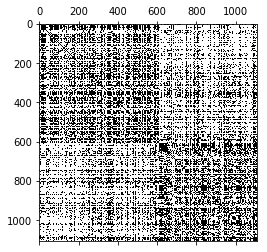

In [124]:
degrees = np.sum(weights, axis=0)
D = np.diag(degrees)
D_0_5 = np.diag(1./np.sqrt(degrees))
laplacian = np.dot(D_0_5, np.dot((D - weights), D_0_5))
plt.spy(laplacian)
plt.show()

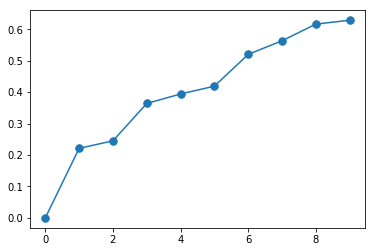

In [125]:
from scipy import sparse, stats, spatial
laplacian = sparse.csr_matrix(laplacian)
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=10, which='SM')
plt.plot(eigenvalues, '.-', markersize=15);

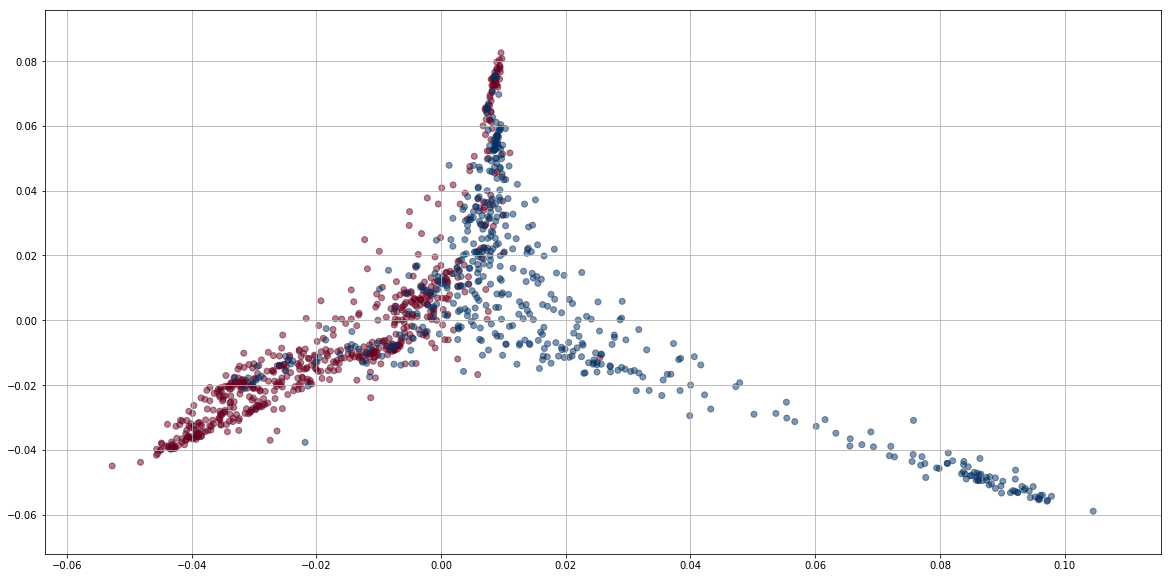

In [126]:
x1 = eigenvectors[:,1]
y1 = eigenvectors[:,2]
labels = np.ones(A.shape[0])
labels[0:609] = 0
plt.figure(figsize=(20,10))
plt.scatter(x1, y1, c=labels, cmap='RdBu', alpha=0.5)
plt.grid()

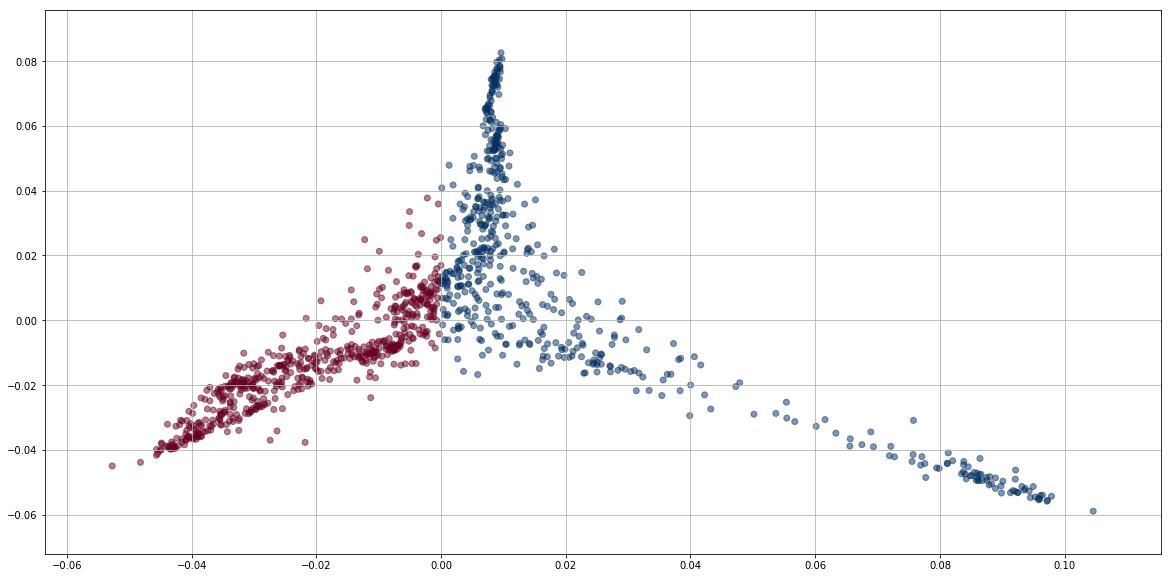

In [127]:
x1 = eigenvectors[:,1]
y1 = eigenvectors[:,2]
plt.figure(figsize=(20,10))
plt.scatter(x1, y1, c=x1>0, cmap='RdBu', alpha=0.5)
plt.grid()

In [128]:
np.sum((x1>0)!=labels)/len(labels)

0.17328519855595667

In [29]:
G_review = nx.Graph()

In [32]:
G_review.add_nodes_from(df_review_chosen.asin.values)

In [41]:
for i in range(len(df_review_chosen)):
    for j in range(i+1, len(df_review_chosen)):
        set_len = len(set(df_review_chosen.iloc[i]['reviewerID'])&set(df_review_chosen.iloc[j]['reviewerID']))
        G_review.add_edge(df_review_chosen.iloc[i]['asin'], df_review_chosen.iloc[j]['asin'], weight=set_len)

In [42]:
A = nx.adjacency_matrix(G_review,weight='weight')
A.todense()

matrix([[0, 0, 5, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [5, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [47]:
similar = A.todense()/A.max()
np.fill_diagonal(similar,0)

In [48]:
A.max()

211

In [45]:
weights = similar.getA().copy()
NEIGHBORS = 50

# Keep only the K strongest edges
# By making weights of all other edges equal to 0
ind = np.argsort(weights)[:,::-1][:,NEIGHBORS:]
for i in range(weights.shape[1]):
    weights[i][ind[i]]=0
    
# Make it symmestric
bigger = weights.transpose() > weights
weights = weights - weights*bigger + weights.transpose()*bigger

In [49]:
weights = similar.getA().copy()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7305: RuntimeWarning: invalid value encountered in greater
  mask = np.abs(Z) > precision


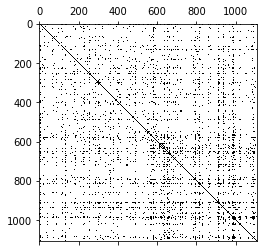

In [50]:
degrees = np.sum(weights, axis=0)
D = np.diag(degrees)
D_0_5 = np.diag(1./np.sqrt(degrees))
laplacian = np.dot(D_0_5, np.dot((D - weights), D_0_5))
plt.spy(laplacian)
plt.show()

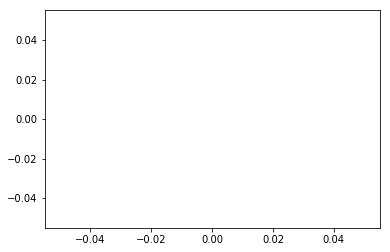

In [51]:
from scipy import sparse, stats, spatial
laplacian = sparse.csr_matrix(laplacian)
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian, k=10, which='SM')
plt.plot(eigenvalues, '.-', markersize=15);